In [ ]:
import jieba #importing chinese language library for data preprocessing
import pandas as pds#importing and aliasing pandas library
import numpy as npy #importing and aliasing numpy
from tensorflow.keras.layers import Dense,Input,Dropout,Embedding,LSTM,Input,Bidirectional#importing important layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
import seaborn as sbr #importing and aliasing seaborn library
import matplotlib.pyplot as mat #importing and aliasing matplotlib library
import nltk #importing nltk for nlp
import re as regular,string #importing and aliasing regular expression  library
nltk.download('punkt');
from tensorflow.keras.utils import plot_model #for plotting model summary
from sklearn.metrics import roc_curve, auc,confusion_matrix, classification_report,accuracy_score #evaluation metrics
from bs4 import BeautifulSoup #for html parser
from sklearn.metrics import precision_score,recall_score, f1_score #evaluation metrics


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
dtf = pds.read_csv("/content/drive/MyDrive/datasetsfolder/weibo/weibo_senti_100k.csv")#data importing
dtf.head()

,label,review
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你]
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...
3,1,美~~~~~[爱你]
4,1,梦想有多大，舞台就有多大![鼓掌]


In [ ]:
dtf['label'].value_counts()#displaying value counts

0    59995
1    59993
Name: label, dtype: int64

**Data Visualization**

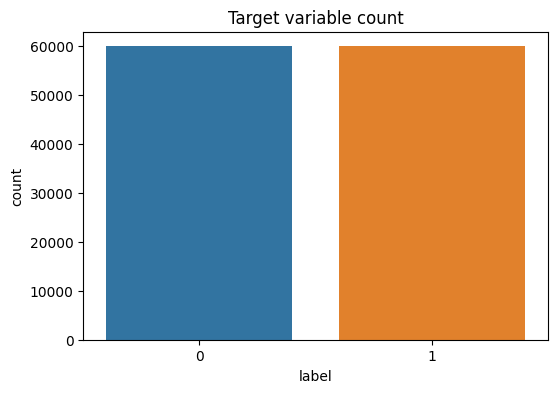

In [ ]:
mat.figure(figsize = (6,4)) #for target variable counts
sbr.countplot(data = dtf,x = dtf['label'])
mat.title("Target variable count")
mat.show()

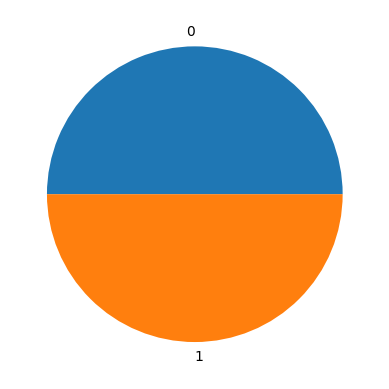

In [ ]:
mat.pie(dtf['label'].value_counts(),labels = dtf['label'].value_counts().index); #for pie chart creation

**Data Preprocessing**

In [ ]:
def mention_remove(t): #removes mentions
    temp =  regular.sub(r'@\w+', '', t) #remove @ symbols
    temp =  regular.sub(r'#\w+', '', temp)#remove # symbols
    temp = "".join([char if char not in string.punctuation else " "  for char in temp])#removing punctuation symbols
    temp = regular.sub(' +', ' ', temp)#replacing spaces with empty spaces
    temp = regular.sub("[0–9]+", "", temp) #converting numeric values to empty
    return regular.sub(r'[^\w\s]', '', temp)

In [ ]:
dtf['review'] = dtf['review'].apply(mention_remove) #applying function

In [ ]:
c_w = lambda a : list(jieba.cut(a)) #data preprocessing using chinese corpus jieba
dtf['reviewed_words'] = dtf['review'].apply(c_w);

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.950 seconds.
DEBUG:jieba:Loading model cost 1.950 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
dtf.head()

,label,review,reviewed_words
0,1,更博了爆照了帅的呀就是越来越爱你生快傻缺 爱你 爱你 爱你,"[更博, 了, 爆照, 了, 帅, 的, 呀, 就是, 越来越, 爱, 你, 生快, 傻, ..."
1,1,土耳其的事要认真对待 哈哈 否则直接开除 很是细心酒店都全部OK啦,"[ , 土耳其, 的, 事要, 认真对待, , 哈哈, , 否则, 直接, 开除, ,..."
2,1,姑娘都羡慕你呢还有招财猫高兴 JC 哈哈 小学徒一枚等着明天见您呢 大佬范儿 书呆子,"[姑娘, 都, 羡慕, 你, 呢, 还有, 招财猫, 高兴, , JC, , 哈哈, ..."
3,1,美 爱你,"[美, , 爱, 你, ]"
4,1,梦想有多大舞台就有多大 鼓掌,"[梦想, 有, 多, 大, 舞台, 就, 有, 多, 大, , 鼓掌, ]"


In [ ]:
m_len = max([len(x) for x in dtf['reviewed_words']]) #selects the maximum length comment

In [ ]:
txt = [' '.join(x) for x in dtf['reviewed_words']] #join the words


In [ ]:
tkz = Tokenizer(num_words=30000) #object creation
tkz.fit_on_texts(txt) #fits the object
sqc = tkz.texts_to_sequences(txt)

In [ ]:
padded_X = pad_sequences(sqc, maxlen=m_len, padding='pre') #finalized the padded data with equal shapes of all texts

In [ ]:
pos = [[0, 1] for _ in range(sum(dtf['label']==1))] #stores 0 labelled count
neg = [[1, 0] for _ in range(sum(dtf['label']==0))] #stores 1 labelled count

In [ ]:
Y = npy.array(pos+ neg) #y is the sum of both 0 and 1

**Model Training and testing**

In [ ]:
trn_x, tst_x, trn_y, tst_y = train_test_split(padded_X, Y, test_size=0.2) #splitting in 80-20

In [ ]:
emb_dims = 128 #embedding layers dimensions

**Bi lstm model**

In [ ]:
model = Sequential([#model creation using keras.models.sequential method
    Embedding(input_dim=30000, output_dim=emb_dims, input_length=m_len), #embedding layer
    Bidirectional(LSTM(64)), #bi lstm layer
    Dense(128, activation='relu'), #dense layer
    Dropout(0.5),#dropout layer as 0.5
    Dense(2, activation='softmax') #dense layer using probability as softmax
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])#model compiling
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 137, 128)          3840000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 3,955,586
Trainable params: 3,955,586
Non-trainable params: 0
______________________________________________

In [ ]:
model.fit(trn_x, trn_y,batch_size=128,epochs=5,validation_data=(tst_x, tst_y)) #model fitting

Epoch 1/5
750/750 [==============================] - 453s 598ms/step - loss: 0.1102 - accuracy: 0.9670 - val_loss: 0.0642 - val_accuracy: 0.9822
Epoch 2/5
750/750 [==============================] - 460s 613ms/step - loss: 0.0498 - accuracy: 0.9816 - val_loss: 0.0543 - val_accuracy: 0.9810
Epoch 3/5
750/750 [==============================] - 447s 595ms/step - loss: 0.0433 - accuracy: 0.9811 - val_loss: 0.0547 - val_accuracy: 0.9825
Epoch 4/5
750/750 [==============================] - 457s 609ms/step - loss: 0.0386 - accuracy: 0.9812 - val_loss: 0.0626 - val_accuracy: 0.9803
Epoch 5/5
750/750 [==============================] - 460s 613ms/step - loss: 0.0343 - accuracy: 0.9816 - val_loss: 0.0775 - val_accuracy: 0.9822


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc']) # proposed model compiled

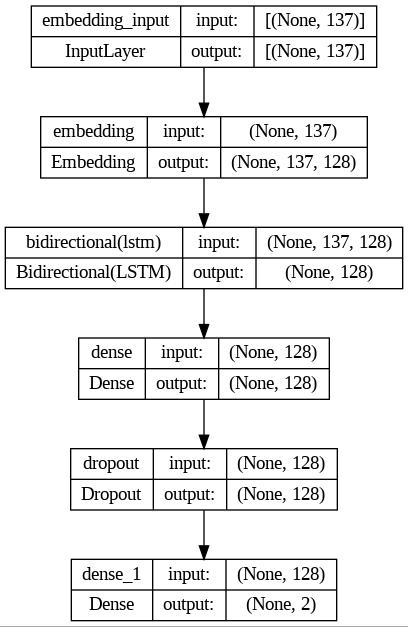

In [ ]:
plot_model(model,to_file = 'proposed_model.jpg',show_shapes = True,show_layer_names = True)  #plot model summary

**Training data results**

In [ ]:
trn_y_p_p = model.predict(trn_x) #predicting on training data
trn_y_pred = (trn_y_p_p >= 0.5).astype(int) #converting float probabilities to 0/1 integer values

3000/3000 [==============================] - 133s 44ms/step


In [ ]:
trn_y_pr_lbl = npy.argmax(trn_y_pred, axis=1)
trn_y_true_labels = npy.argmax(trn_y, axis=1)
trn_acc = accuracy_score(trn_y_true_labels, trn_y_pr_lbl)

In [ ]:
print("Training accuracy ",trn_acc)#Training accuracy
print("Training precision_score ",precision_score(trn_y_true_labels, trn_y_pr_lbl))#Training precision_score
print("Training recall_score " ,recall_score(trn_y_true_labels, trn_y_pr_lbl))#Training recall_score
print("Training f1_score ",f1_score(trn_y_true_labels, trn_y_pr_lbl))#Training f1_score

Training accuracy  0.982060631315762
Training precision_score  0.9999784264233167
Training recall_score  0.9642002787427454
Training f1_score  0.9817634973418338


In [ ]:
# Generate the classification report
class_report = classification_report(trn_y_true_labels, trn_y_pr_lbl)#classification report training data
print(class_report )

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     47917
           1       1.00      0.96      0.98     48073

    accuracy                           0.98     95990
   macro avg       0.98      0.98      0.98     95990
weighted avg       0.98      0.98      0.98     95990



<Axes: >

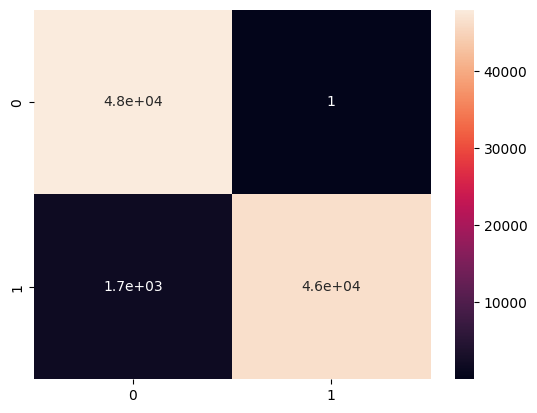

In [ ]:
trn_c_mat = confusion_matrix(trn_y_true_labels, trn_y_pr_lbl)#training confusion matrix
sbr.heatmap(trn_c_mat ,annot=True )#training heatmap

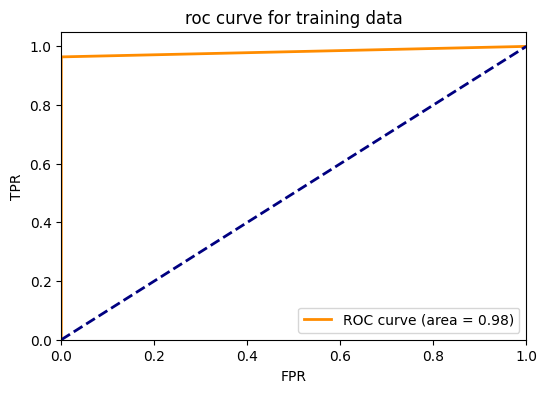

In [ ]:
#roc curve for training data
y_true = tst_y.flatten()
f_p_r, t_p_r, THR = roc_curve(trn_y_true_labels, trn_y_pr_lbl)
roc_auc = auc(f_p_r, t_p_r)
mat.figure(figsize=(6, 4))
mat.plot(f_p_r, t_p_r, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
mat.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
mat.xlim([0.0, 1.0])
mat.ylim([0.0, 1.05])
mat.xlabel('FPR')
mat.ylabel('TPR')
mat.title('roc curve for training data')
mat.legend(loc="lower right")
mat.show()

**Testing data results**

In [ ]:
tst_y_pred = model.predict(tst_x) #testing data prediction

750/750 [==============================] - 32s 43ms/step


In [ ]:
tst_y_pr_lbl = npy.argmax(tst_y_pred, axis=1)

In [ ]:
tst_y_true_labels = npy.argmax(tst_y, axis=1)

In [ ]:
tst_acc = accuracy_score(tst_y_true_labels, tst_y_pr_lbl)#testing data accuracy

In [ ]:
print("Test Accuracy:", tst_acc)#testing accuracy
print("Test precision:", precision_score(tst_y_true_labels, tst_y_pr_lbl))#testing precision
print("Test recall:", recall_score(tst_y_true_labels, tst_y_pr_lbl))#testing recall
print("Test f1_score:", f1_score(tst_y_true_labels, tst_y_pr_lbl))#testing f1_score

Test Accuracy: 0.9821651804317026
Test precision: 0.999739085058271
Test recall: 0.9643456375838926
Test f1_score: 0.9817234605858741


In [ ]:
print("\nClassification Report:")
print(class_report) #classification report of testing data


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     47917
           1       1.00      0.96      0.98     48073

    accuracy                           0.98     95990
   macro avg       0.98      0.98      0.98     95990
weighted avg       0.98      0.98      0.98     95990



<Axes: >

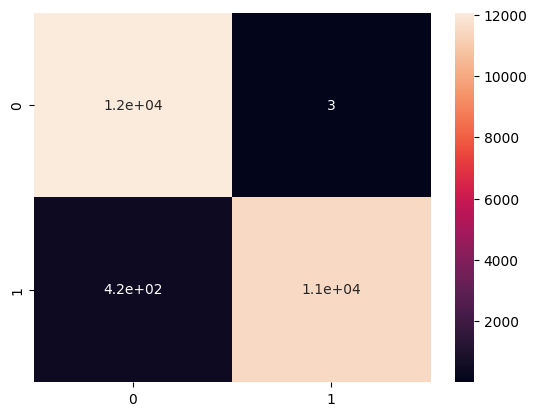

In [ ]:
tst_c_mat = confusion_matrix(tst_y_true_labels, tst_y_pr_lbl) #test conf matrix
sbr.heatmap(tst_c_mat ,annot=True )#testing heatmap


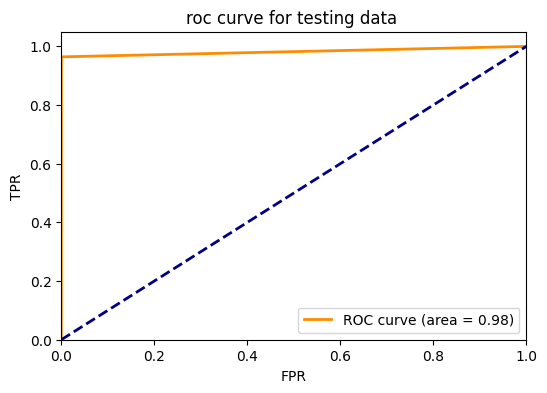

In [ ]:
#roc curve for testing data
y_true = tst_y.flatten()

f_p_r, t_p_r, THR = roc_curve(tst_y_true_labels, tst_y_pr_lbl)

roc_auc = auc(f_p_r, t_p_r)

mat.figure(figsize=(6, 4))
mat.plot(f_p_r, t_p_r, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
mat.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
mat.xlim([0.0, 1.0])
mat.ylim([0.0, 1.05])
mat.xlabel('FPR')
mat.ylabel('TPR')
mat.title('roc curve for testing data ')
mat.legend(loc="lower right")
mat.show()
